# Telco Churn Modelling
Models to be trained and evaluated:
* Nearest Centroid - Baseline Model
* Logistic Regression
* Support Vector Machines
* Random Forest Classifier
* Nearest Component Analyusis + K-Nearest Neighbours

## Evaluation Metric : Recall
The models' performances will be evaluated on their Recall. We believe that recall is the most appropriate metric for this problem.

We want to correctly identify as many potential churn customers as possible, in order to target them with promotions to entice them to remain with the Telco.

The cost of not identifying a potential churn customer (__False Negative__) is __more costly__ than incorrectly identifying a churn target (__False Positive__). This is under the reasonable assumption that the cost of losing a customer is greater than the cost incurred for promotions and marketing. 

Although recall will be our primary metric, we will also be using the precision-recall curve to optimize the thresholds for our models.

#### Importing Libraries

In [1]:
# Standard Tools
from scipy import stats
import pandas as pd
import numpy as np
import warnings
import pickle
import time
import sys 
# sys.path.insert(0, '/home/yeokoso/Documents/ml_scripts') # Laptop Path
sys.path.insert(0, 'C:\\Users\\Joshua\\Documents\\DS_Projects\ml_scripts') # PC path
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.svm import LinearSVC, SVC

# Sampling Tools
from imblearn.over_sampling import SMOTE, ADASYN, KMeansSMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline

# Visualisation
from yellowbrick.classifier import DiscriminationThreshold
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_formate = 'retina'
plt.style.use('fivethirtyeight')

# Random State
SEED = 8888

#### Loading our Data and Splitting into Training and Testing sets

In [2]:
with open('cleaned_dataset_all_levels.pickle', 'rb') as f:
    df = pickle.load(f)

In [3]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,InternetService_DSL,InternetService_Fiber_optic,InternetService_No,Contract_Month_to_month,Contract_One_year,Contract_Two_year,PaymentMethod_Bank_Transfer,PaymentMethod_Credit_Card,PaymentMethod_E_Check,PaymentMethod_Check
0,0,0,1,0,1,0,0,1,0,0,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,1,0,1,0,...,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,1,0,0,...,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,1,0,1,1,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0


In [4]:
X = df.drop('Churn', axis = 1)
y = df.Churn

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

In [6]:
# Defining our cross validation method
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [7]:
# Kwargs for cross_validate method
cv_kwargs = {
    'scoring' : 'recall',
    'cv' : skf,
    'n_jobs' : -1,
    'return_train_score' : True,
    'verbose' : False,
    'return_estimator' : True
}

In [8]:
def get_best_estimator(cv_results):
    ''' Function that returns the best estimator found during cross valiation.
    Arguments:
        cv_results : dict
            Results from Sklearn's cross_validate method.
    
    Returns:
        best_estimator : Sklearn estimator object
            Best estimator found during cross validation.
    '''
    scores = list(cv_results['test_score'])
    max_score_index = scores.index(max(scores))
    best_estimator = cv_results['estimator'][max_score_index]
    
    return best_estimator

In [9]:
def model_results_summary(model, X_train, y_train, X_test, y_test, cv_kwargs, model_name='', threshold=0.5, return_estimator=True):
    cv_results = cross_validate(model, X_train, y_train, **cv_kwargs)
    
    avg_train_score = np.mean(cv_results['train_score']) * 100
    avg_valid_score = np.mean(cv_results['test_score']) * 100
    avg_training_time = np.mean(cv_results['fit_time'])
    avg_predict_time = np.mean(cv_results['score_time'])
    
    best_model = get_best_estimator(cv_results)
    best_model.fit(X_train, y_train)
    
    # Class predictions
    if threshold != 0.5:
        y_pred = np.where(best_model.predict_proba(X_test)[:,1] > threshold, 1, 0)
    else:
        y_pred = best_model.predict(X_test)
        
    title = f'{model_name} CV Results Summary'
    len_title = len(title)
    report_title = f'Holdout Dataset Classification Report for {model_name}'
    report_title_len = len(report_title)
    metric = cv_kwargs['scoring'].capitalize()
    
    print(title)
    print('=' * len_title)
    print(f'Mean Training {metric}', '\t', '{:.2f}%'.format(avg_train_score))
    print(f'Mean Validation {metric}', '\t', '{:.2f}%'.format(avg_valid_score))
    print()
    print('Mean Fitting Time', '\t', '{:.4f}s'.format(avg_training_time))
    print('Mean Scoring Time', '\t', '{:.4f}s'.format(avg_predict_time))
    print()
    print(report_title)
    print('=' * report_title_len)
    print(classification_report(y_test, y_pred))
    
    if return_estimator:
        return best_model

In [10]:
def model_predictions(model, X_train, y_train, X_test, threshold=0.5, predict_probability=True):
    '''Function that fits a Sklearn estimator object and returns predictions.
    Arguments:
        model : Sklearn estimator object
        predict_probability : bool, default = True
            Returns class probabilities for binary classifiers
    Returns:
        y_pred : array
            Predicted target values
        y_probab : array
            Predicted class probabilities for the positive class
    '''
    model.fit(X_train, y_train)
    if threshold == 0.5:
        y_pred = model.predict(X_test)
    else:
        y_pred = np.where(model.predict_proba(X_test)[:,1] > threshold, 1, 0)
    
    if predict_probability:
        y_proba = model.predict_proba(X_test)[:,1]
        return y_pred, y_proba
    
    else:
        return y_pred

In [11]:
def results_visualisations(model, X_train, y_train, X_test, y_test, random_state, threshold=0.5):
    y_pred, y_proba = model_predictions(model, X_train, y_train, X_test, predict_probability=True, threshold=threshold)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    conf_matrix = confusion_matrix(y_test, y_pred)

    fig = plt.figure(figsize=(10,12))
    plt.style.use('fivethirtyeight')
    gs = GridSpec(2,2, height_ratios=[2,3])
    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[0,1])
    ax3 = fig.add_subplot(gs[1,:])
    plt.subplots_adjust(hspace=0.3)
    
    # ROC Curve Plot
    ax1.plot(fpr, tpr)
    ax1.plot([0,1], [0,1], c='orange', ls='--')
    ax1.set_title('ROC Curve', size=18, y=1.05)
    ax1.set_ylabel('True Positive Rate', size=16)
    ax1.set_xlabel('False Positive Rate', size=16)
    ax1.tick_params(axis='both', which='major', labelsize=14)

    # Confusion Matrix Heatmap
    sns.heatmap(conf_matrix, cmap='Blues', annot=True, annot_kws={'size':16}, fmt='g', ax=ax2)
    ax2.set_title('Confusion Matrix', size=18, y=1.05)
    ax2.set_ylabel('Actual Class', size=16)
    ax2.set_xlabel('Predicted Class', size=16)
    ax2.tick_params(axis='both', which='major', labelsize=14)
    cbar = ax2.collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)

    # Discrimination Threshold Plot
    visualiser = DiscriminationThreshold(model, ax=ax3, n_trials=5, cv=0.2, exclude='queue_rate',
                                         random_state=random_state, title='Threshold Plot')
    visualiser.fit(X_train, y_train)
    ax3.set_title('Threshold Plot', size=18, y=1.05)
    ax3.tick_params(axis='both', which='major', labelsize=14)
    plt.rcParams["legend.fontsize"] = 14
    visualiser.show();

In [12]:
def model_report(model, X_train , y_train, X_test, y_test, model_name, threshold=0.5):
    model.fit(X_train, y_train)
    y_pred = model_predictions(model, X_train, y_train, X_test, predict_probability=False)
    
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred) 
    
    df = pd.DataFrame({
        'Model' : [model_name],
        'Accuracy' : [accuracy],
        'ROC_AUC' : [roc_auc],
        'Precision' : [precision],
        'Recall' : [recall],
        'F1' : [f1]
    })
    
    df = df.round(3)
    return df

## Baseline Model : Nearest Centroid Classifier
The Nearest Centroid Classifier is a simple algorithm that represents each class by the __centroid of its members__, similar to the label updating phase of the K-Means algorithm. Furthermore, there are __no parameters to choose__ from, making it a __good baseline classifier__.

In [13]:
ncc_pipe = Pipeline(steps=[
    ('Standardise', StandardScaler()),
    ('NearestCentroid', NearestCentroid())
])

ncc_model = model_results_summary(ncc_pipe, X_train, y_train, X_test, y_test, cv_kwargs,
                                  model_name='Nearest Centroid')

Nearest Centroid CV Results Summary
Mean Training Recall 	 80.33%
Mean Validation Recall 	 80.00%

Mean Fitting Time 	 0.0086s
Mean Scoring Time 	 0.0024s

Holdout Dataset Classification Report for Nearest Centroid
              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1033
           1       0.49      0.78      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.74      1407



In [14]:
# Saving results to a dataframe
ncc_base = model_report(ncc_model, X_train , y_train, X_test, y_test, 'NearestCentroid', threshold=0.5)

### Oversampling Minority Class
Our dataset is imbalanced with only around 25% of observations being Churn customers. As our dataset is relatively small at 7000 observations, we will attempt some over sampling techniques and observe if they improve our modelling results.

Over Sampling Methods:
* Random Over Sampling
* Synthetic Minority Over Sampling (SMOTE)
* Adaptive Synthetic Over Sampling (ADASYN)

In [15]:
# Instantiating our Resamplers
ros = RandomOverSampler(random_state=SEED)
smote = SMOTE(random_state=SEED)
adasyn = ADASYN(random_state=SEED)

#### Random Over Sampling

In [16]:
ros_ncc_pipe = Pipeline(steps=[
    ('RandomOverSampler', ros),
    ('Standardise', StandardScaler()),
    ('NearestCentroid', NearestCentroid())
])

ros_ncc_model = model_results_summary(ros_ncc_pipe, X_train, y_train, X_test, y_test, cv_kwargs,
                                      model_name='ROS Nearest Centroid')

ROS Nearest Centroid CV Results Summary
Mean Training Recall 	 81.19%
Mean Validation Recall 	 81.07%

Mean Fitting Time 	 0.0144s
Mean Scoring Time 	 0.0026s

Holdout Dataset Classification Report for ROS Nearest Centroid
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1033
           1       0.49      0.79      0.60       374

    accuracy                           0.72      1407
   macro avg       0.69      0.74      0.69      1407
weighted avg       0.79      0.72      0.74      1407



In [17]:
# Saving results to df
ncc_ros = model_report(ros_ncc_model, X_train , y_train, X_test, y_test, 'ROS_NearestCentroid')

#### SMOTE

In [18]:
smote_ncc_pipe = Pipeline(steps=[
    ('SMOTE', smote),
    ('Standardise', StandardScaler()),
    ('NearestCentroid', NearestCentroid())
])

smote_ncc_model = model_results_summary(smote_ncc_pipe, X_train, y_train, X_test, y_test, cv_kwargs,
                                        model_name='SMOTE Nearest Centroid')

SMOTE Nearest Centroid CV Results Summary
Mean Training Recall 	 80.72%
Mean Validation Recall 	 80.47%

Mean Fitting Time 	 0.0345s
Mean Scoring Time 	 0.0026s

Holdout Dataset Classification Report for SMOTE Nearest Centroid
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1033
           1       0.49      0.79      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.74      1407



In [19]:
# Saving results to dataframe
ncc_smote = model_report(smote_ncc_model, X_train , y_train, X_test, y_test, 'SMOTE_NearestCentroid')

#### ADASYN

In [23]:
adasyn_ncc_pipe = Pipeline(steps=[
    ('ADASYN', adasyn),
    ('Standardise', StandardScaler()),
    ('NearestCentroid', NearestCentroid())
])

adasyn_ncc_model = model_results_summary(adasyn_ncc_pipe, X_train, y_train, X_test, y_test, cv_kwargs,
                                         model_name='ADASYN Nearest Centroid')

ADASYN Nearest Centroid CV Results Summary
Mean Training Recall 	 81.99%
Mean Validation Recall 	 81.87%

Mean Fitting Time 	 0.0828s
Mean Scoring Time 	 0.0028s

Holdout Dataset Classification Report for ADASYN Nearest Centroid
              precision    recall  f1-score   support

           0       0.90      0.67      0.77      1033
           1       0.47      0.80      0.59       374

    accuracy                           0.71      1407
   macro avg       0.69      0.74      0.68      1407
weighted avg       0.79      0.71      0.72      1407



In [21]:
ncc_adasyn = model_report(adasyn_ncc_model, X_train , y_train, X_test, y_test, 'ADASYN_NearestCentroid')

### Comparing Resampling Results

In [22]:
ncc_performance = pd.concat([ncc_base, ncc_ros, ncc_smote, ncc_adasyn], axis=0)
ncc_performance

,Model,Accuracy,ROC_AUC,Precision,Recall,F1
0,NearestCentroid,0.729,0.746,0.493,0.783,0.605
0,ROS_NearestCentroid,0.722,0.744,0.486,0.791,0.602
0,SMOTE_NearestCentroid,0.726,0.747,0.490,0.794,0.606
0,ADASYN_NearestCentroid,0.707,0.737,0.470,0.799,0.592


From the results of the Nearest Centroid modelling, we observe that the oversampling techniques did not improve the baseline performance by much. However, it seems that over sampling with SMOTE gives a decent improvement in recall of 1% without much loss in precision when compared to the baseline model. Although ADASYN had the best recall, it came at the expense of much poorer precision. Therefore, the SMOTE Nearest Centroid model will be used for comparison with the other models. 

### Nearest Component Analysis and Nearest Neighbours

In [83]:
knn_pipe = Pipeline(steps=[
    ('Standardise', StandardScaler()),
    ('KNN', KNeighborsClassifier())
])

In [84]:
tune_knn_params = {
    'KNN__n_neighbors' : np.arange(3,16, step=2),
    'KNN__weights' : ['uniform', 'distance'],
    'KNN__algorithm' : ['ball_tree', 'kd_tree'],
    'KNN__metric' : ['euclidean', 'manhattan'],
    'KNN__n_jobs' : [-1]
}

In [85]:
knn_gscv = GridSearchCV(knn_pipe, tune_knn_params, scoring='recall', n_jobs=-1, cv=skf,
                        return_train_score=True)

knn_gscv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=8888, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('Standardise',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('KNN',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weig

In [86]:
knn_kwargs = knn_gscv.best_params_
knn_kwargs

{'KNN__algorithm': 'ball_tree',
 'KNN__metric': 'manhattan',
 'KNN__n_jobs': -1,
 'KNN__n_neighbors': 13,
 'KNN__weights': 'uniform'}

In [88]:
knn_tuned = knn_gscv.best_estimator_

knn_tuned = model_results_summary(knn_tuned, X_train, y_train, X_test, y_test, cv_kwargs,
                                  model_name='K-Nearest Neighbours')

K-Nearest Neighbours CV Results Summary
Mean Training Recall 	 59.00%
Mean Validation Recall 	 53.51%

Mean Fitting Time 	 0.0405s
Mean Scoring Time 	 0.2781s

Holdout Dataset Classification Report for K-Nearest Neighbours
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1033
           1       0.61      0.56      0.58       374

    accuracy                           0.79      1407
   macro avg       0.73      0.71      0.72      1407
weighted avg       0.78      0.79      0.78      1407



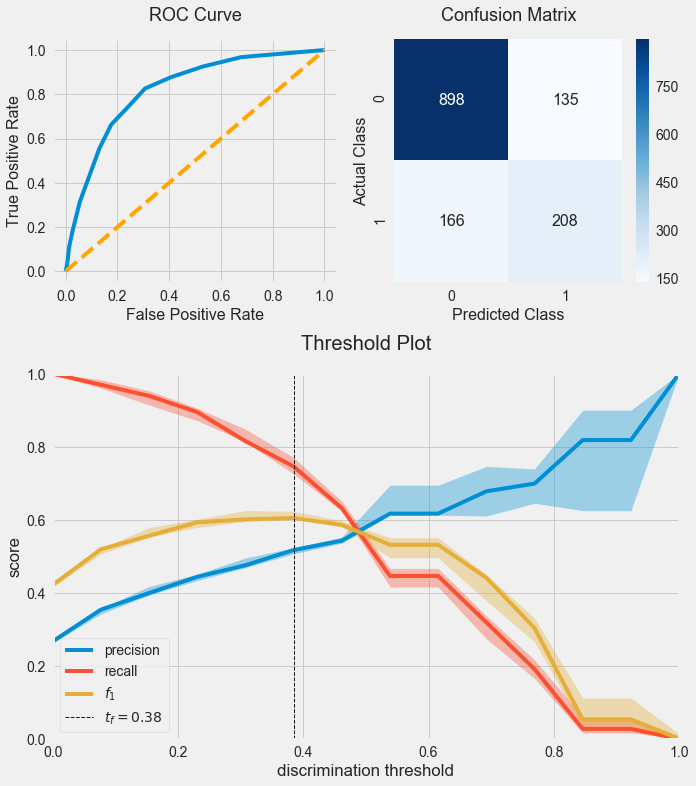

In [89]:
results_visualisations(knn_tuned, X_train, y_train, X_test, y_test, random_state=SEED)

In [114]:
knn_base = model_report(knn_tuned, X_train, y_train, X_test, y_test, 'KNN')

In [90]:
test = model_results_summary(knn_tuned, X_train, y_train, X_test, y_test, cv_kwargs,
                             model_name='K-Nearest Neighbours', threshold=0.38)

K-Nearest Neighbours CV Results Summary
Mean Training Recall 	 59.00%
Mean Validation Recall 	 53.51%

Mean Fitting Time 	 0.0435s
Mean Scoring Time 	 0.3110s

Holdout Dataset Classification Report for K-Nearest Neighbours
              precision    recall  f1-score   support

           0       0.89      0.75      0.82      1033
           1       0.52      0.75      0.62       374

    accuracy                           0.75      1407
   macro avg       0.71      0.75      0.72      1407
weighted avg       0.79      0.75      0.76      1407



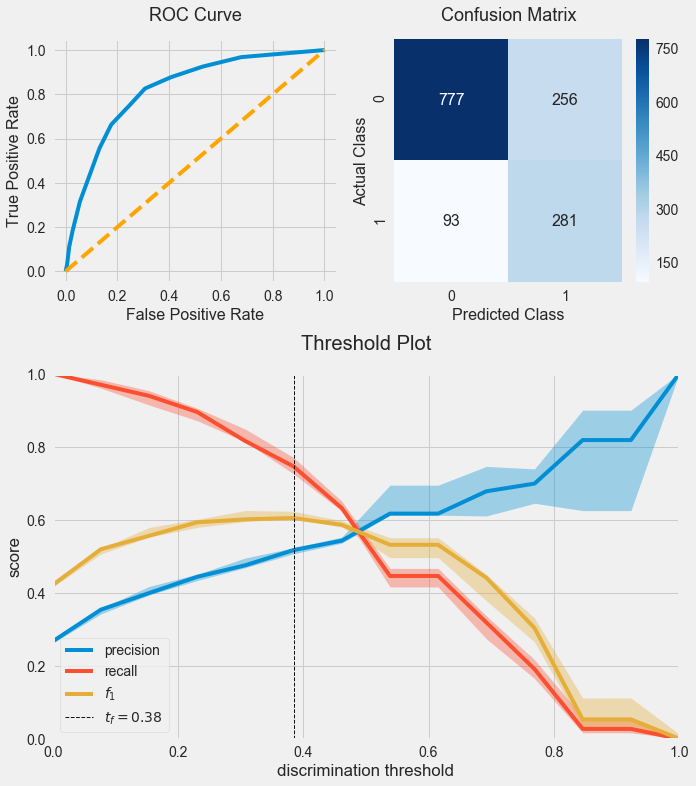

In [91]:
results_visualisations(test, X_train, y_train, X_test, y_test, random_state=SEED, threshold=0.38)

It appears that the KNN algorithm performs veru poorly in for this classification task. We will try the different over sampling methods to compare if the results improve.

### Random Over Sampler 

In [96]:
ros_knn_pipe = Pipeline(steps=[
    ('RandomOverSample', ros),
    ('Standardise', StandardScaler()),
    ('KNN', KNeighborsClassifier())
])

ros_knn_gscv = GridSearchCV(ros_knn_pipe, tune_knn_params, scoring='recall', n_jobs=-1, cv=skf,
                            return_train_score=True)

ros_knn_gscv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=8888, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('RandomOverSample',
                                        RandomOverSampler(random_state=8888,
                                                          ratio=None,
                                                          return_indices=False,
                                                          sampling_strategy='auto')),
                                       ('Standardise',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('KNN',
                                        KNeighborsClassifier(algorit...
                                                             n_neighbors=5, p=2,
          

In [97]:
ros_knn_kwargs = ros_knn_gscv.best_params_
ros_knn_kwargs

{'KNN__algorithm': 'ball_tree',
 'KNN__metric': 'manhattan',
 'KNN__n_jobs': -1,
 'KNN__n_neighbors': 13,
 'KNN__weights': 'uniform'}

In [98]:
ros_knn_tuned = ros_knn_gscv.best_estimator_

ros_knn_tuned = model_results_summary(ros_knn_tuned, X_train, y_train, X_test, y_test, cv_kwargs,
                                      model_name='ROS K-Nearest Neighbours')

ROS K-Nearest Neighbours CV Results Summary
Mean Training Recall 	 86.51%
Mean Validation Recall 	 79.93%

Mean Fitting Time 	 0.0652s
Mean Scoring Time 	 0.3223s

Holdout Dataset Classification Report for ROS K-Nearest Neighbours
              precision    recall  f1-score   support

           0       0.91      0.68      0.78      1033
           1       0.48      0.82      0.61       374

    accuracy                           0.72      1407
   macro avg       0.70      0.75      0.69      1407
weighted avg       0.80      0.72      0.73      1407



In [105]:
knn_ros = model_report(ros_knn_tuned, X_train, y_train, X_test, y_test, 'ROS_KNN')

### SMOTE

In [101]:
smote_knn_pipe = Pipeline(steps=[
    ('Smote', smote),
    ('Standardise', StandardScaler()),
    ('KNN', KNeighborsClassifier())
])

smote_knn_gscv = GridSearchCV(smote_knn_pipe, tune_knn_params, scoring='recall', n_jobs=-1, cv=skf,
                              return_train_score=True)

smote_knn_gscv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=8888, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('SMOTE',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='deprecated',
                                              n_jobs=1, out_step='deprecated',
                                              random_state=8888, ratio=None,
                                              sampling_strategy='auto',
                                              svm_estimator='deprecated')),
                                       ('Standardise',
                                        StandardScaler(copy=...
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
           

In [103]:
smote_knn_kwargs = smote_knn_gscv.best_params_
smote_knn_kwargs

{'KNN__algorithm': 'ball_tree',
 'KNN__metric': 'euclidean',
 'KNN__n_jobs': -1,
 'KNN__n_neighbors': 15,
 'KNN__weights': 'uniform'}

In [104]:
smote_knn_tuned = smote_knn_gscv.best_estimator_

smote_knn_tuned = model_results_summary(smote_knn_tuned, X_train, y_train, X_test, y_test, cv_kwargs,
                                        model_name='SMOTE K-Nearest Neighbours')

SMOTE K-Nearest Neighbours CV Results Summary
Mean Training Recall 	 86.10%
Mean Validation Recall 	 79.53%

Mean Fitting Time 	 0.1001s
Mean Scoring Time 	 0.3371s

Holdout Dataset Classification Report for SMOTE K-Nearest Neighbours
              precision    recall  f1-score   support

           0       0.90      0.69      0.78      1033
           1       0.48      0.79      0.60       374

    accuracy                           0.72      1407
   macro avg       0.69      0.74      0.69      1407
weighted avg       0.79      0.72      0.73      1407



In [106]:
knn_smote = model_report(smote_knn_tuned, X_train, y_train, X_test, y_test, 'SMOTE_KNN')

### ADASYN

In [110]:
adasyn_knn_pipe = Pipeline(steps=[
    ('Adasyn', adasyn),
    ('Standardise', StandardScaler()),
    ('KNN', KNeighborsClassifier())
])

adasyn_knn_gscv = GridSearchCV(adasyn_knn_pipe, tune_knn_params, scoring='recall', n_jobs=-1, cv=skf,
                              return_train_score=True)

adasyn_knn_gscv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=8888, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('Adasyn',
                                        ADASYN(n_jobs=1, n_neighbors=5,
                                               random_state=8888, ratio=None,
                                               sampling_strategy='auto')),
                                       ('Standardise',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('KNN',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size...
                                                             n_neighbors=5, p=2,
                           

In [111]:
adasyn_knn_kwargs = adasyn_knn_gscv.best_params_
adasyn_knn_kwargs

{'KNN__algorithm': 'ball_tree',
 'KNN__metric': 'euclidean',
 'KNN__n_jobs': -1,
 'KNN__n_neighbors': 15,
 'KNN__weights': 'uniform'}

In [112]:
adasyn_knn_tuned = adasyn_knn_gscv.best_estimator_

adasyn_knn_tuned = model_results_summary(adasyn_knn_tuned, X_train, y_train, X_test, y_test, cv_kwargs,
                                         model_name='ADASYN K-Nearest Neighbours')

ADASYN K-Nearest Neighbours CV Results Summary
Mean Training Recall 	 89.41%
Mean Validation Recall 	 81.14%

Mean Fitting Time 	 0.1568s
Mean Scoring Time 	 0.3648s

Holdout Dataset Classification Report for ADASYN K-Nearest Neighbours
              precision    recall  f1-score   support

           0       0.91      0.66      0.76      1033
           1       0.46      0.81      0.59       374

    accuracy                           0.70      1407
   macro avg       0.68      0.73      0.67      1407
weighted avg       0.79      0.70      0.72      1407



In [113]:
knn_adasyn = model_report(adasyn_knn_tuned, X_train, y_train, X_test, y_test, 'ADASYN_KNN')

### Comparing Performance

In [116]:
knn_performance = pd.concat([knn_base, knn_ros, knn_smote, knn_adasyn], axis=0)
knn_performance

,Model,Accuracy,ROC_AUC,Precision,Recall,F1
0,KNN,0.786,0.713,0.606,0.556,0.580
0,ROS_KNN,0.719,0.750,0.483,0.818,0.607
0,SMOTE_KNN,0.717,0.741,0.481,0.791,0.598
0,ADASYN_KNN,0.698,0.735,0.461,0.813,0.589


## Logistic Regression

### Hyper Parameter Tuning

In [24]:
# Range of Cs to try during cross validation
cs_params = np.logspace(-3,2,6)

In [25]:
logreg_cv_params = {
    'Cs' : cs_params,
    'cv' : skf,
    'class_weight' : 'balanced',
    'penalty' : 'l2',
    'solver' : 'lbfgs',
    'scoring' : 'recall',
    'max_iter' : 1000,
    'n_jobs' : -1,
    'random_state' : SEED
}

In [26]:
logreg = LogisticRegressionCV(**logreg_cv_params)
logreg.fit(X_train, y_train)

# Optimal C for logistic regression
logreg.C_

array([0.1])

### Model Performance 

In [44]:
# Updating logistic regression params
logreg_params = {
    'C' : 0.1,
    'class_weight' : 'balanced',
    'penalty' : 'l2',
    'solver' : 'lbfgs',
    'max_iter' : 1000,
    'n_jobs' : -1,
    'random_state' : SEED
}

In [45]:
# Reinstantiating our model with optimal C
logreg = LogisticRegression(**logreg_params)

# Saving optimal estimator and displaying model performance results
logreg_model = model_results_summary(logreg, X_train, y_train, X_test, y_test, cv_kwargs,
                                     model_name='Logistic Regression')

Logistic Regression CV Results Summary
Mean Training Recall 	 80.18%
Mean Validation Recall 	 80.00%

Mean Fitting Time 	 0.1081s
Mean Scoring Time 	 0.0018s

Holdout Dataset Classification Report for Logistic Regression
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1033
           1       0.51      0.81      0.62       374

    accuracy                           0.74      1407
   macro avg       0.71      0.76      0.71      1407
weighted avg       0.80      0.74      0.75      1407



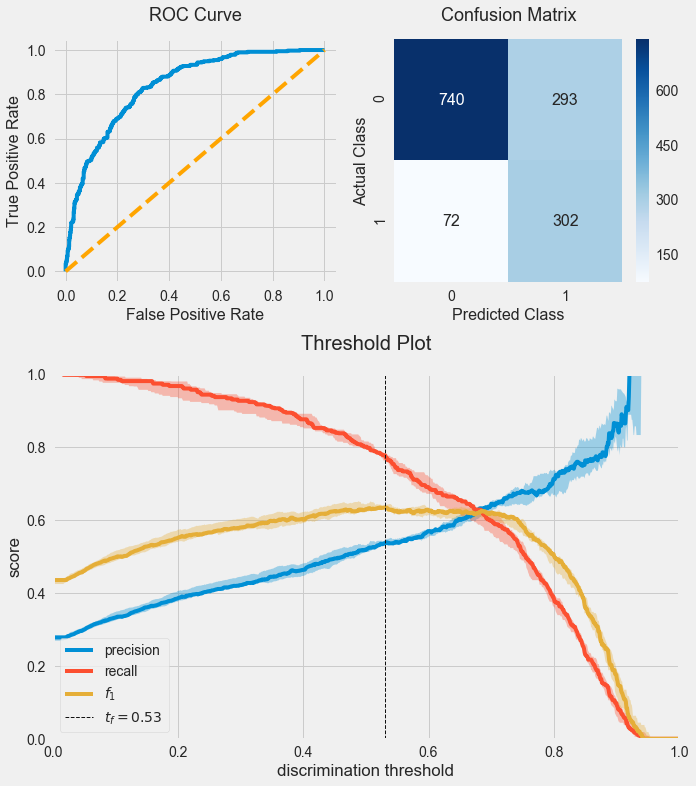

In [46]:
results_visualisations(logreg_model, X_train, y_train, X_test, y_test, SEED)

# Saving results to dataframe
logreg_base = model_report(logreg_model, X_train , y_train, X_test, y_test, 'LogisticRegression')

### Random Over Sampling

In [47]:
ros_logreg_pipe = Pipeline(steps=[
    ('RandomOverSample', ros),
    ('LogReg', LogisticRegression(**logreg_params))
])

ros_logreg = model_results_summary(ros_logreg_pipe, X_train, y_train, X_test, y_test,
                                   cv_kwargs, model_name='ROS Logistic Regression')

ROS Logistic Regression CV Results Summary
Mean Training Recall 	 80.79%
Mean Validation Recall 	 80.07%

Mean Fitting Time 	 0.1720s
Mean Scoring Time 	 0.0024s

Holdout Dataset Classification Report for ROS Logistic Regression
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1033
           1       0.51      0.81      0.62       374

    accuracy                           0.74      1407
   macro avg       0.71      0.76      0.71      1407
weighted avg       0.80      0.74      0.76      1407



In [48]:
logreg_ros = model_report(ros_logreg, X_train, y_train, X_test, y_test, 'ROS_LogisticRegression')

### SMOTE

In [49]:
smote_logreg_pipe = Pipeline(steps=[
    ('Smote', smote),
    ('LogReg', LogisticRegression(**logreg_params))
])

smote_logreg = model_results_summary(smote_logreg_pipe, X_train, y_train, X_test, y_test,
                                     cv_kwargs, model_name='SMOTE Logistic Regression')

SMOTE Logistic Regression CV Results Summary
Mean Training Recall 	 79.68%
Mean Validation Recall 	 78.93%

Mean Fitting Time 	 0.2123s
Mean Scoring Time 	 0.0022s

Holdout Dataset Classification Report for SMOTE Logistic Regression
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1033
           1       0.50      0.80      0.62       374

    accuracy                           0.74      1407
   macro avg       0.71      0.76      0.71      1407
weighted avg       0.80      0.74      0.75      1407



In [50]:
# Saving results to dataframe
logreg_smote = model_report(smote_logreg, X_train, y_train, X_test, y_test, 'SMOTE_LogisticRegression')

### ADASYN

In [51]:
adasyn_logreg_pipe = Pipeline(steps=[
    ('Adasyn', adasyn),
    ('LogReg', LogisticRegression(**logreg_params))
])

adasyn_logreg = model_results_summary(adasyn_logreg_pipe, X_train, y_train, X_test, y_test, 
                                      cv_kwargs, model_name='ADASYN Logistic Regression')

ADASYN Logistic Regression CV Results Summary
Mean Training Recall 	 82.79%
Mean Validation Recall 	 82.68%

Mean Fitting Time 	 0.2019s
Mean Scoring Time 	 0.0020s

Holdout Dataset Classification Report for ADASYN Logistic Regression
              precision    recall  f1-score   support

           0       0.92      0.69      0.79      1033
           1       0.49      0.82      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.76      0.70      1407
weighted avg       0.80      0.73      0.74      1407



In [52]:
# Saving results to dataframe
logreg_adasyn = model_report(adasyn_logreg, X_train, y_train, X_test, y_test, 'ADASYN_LogisticRegression')

### Comparing Baseline vs Resampling Methods

In [53]:
logreg_performance = pd.concat([logreg_base, logreg_ros, logreg_smote, logreg_adasyn], axis=0)
logreg_performance

,Model,Accuracy,ROC_AUC,Precision,Recall,F1
0,LogisticRegression,0.741,0.762,0.508,0.807,0.623
0,ROS_LogisticRegression,0.741,0.762,0.508,0.807,0.624
0,SMOTE_LogisticRegression,0.738,0.757,0.504,0.797,0.618
0,ADASYN_LogisticRegression,0.726,0.757,0.490,0.824,0.615


## Random Forest Classifier

#### Pre-tuned Random Forest

In [68]:
rforest = RandomForestClassifier(random_state=SEED, n_jobs=-1) 

rforest_untuned = model_results_summary(rforest, X_train, y_train, X_test, y_test, cv_kwargs,
                                        model_name='Random Forest')

Random Forest CV Results Summary
Mean Training Recall 	 99.57%
Mean Validation Recall 	 47.96%

Mean Fitting Time 	 0.2925s
Mean Scoring Time 	 0.1061s

Holdout Dataset Classification Report for Random Forest
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1033
           1       0.66      0.52      0.58       374

    accuracy                           0.80      1407
   macro avg       0.75      0.71      0.72      1407
weighted avg       0.79      0.80      0.79      1407



We observe that the baseline random forest classifier is overfitting the data. Lets do some hyper paramter tuning to improve its performance.

In [69]:
tune_rforest_params = {
    'n_estimators' : [100],
    'max_depth' : [5, 10, 15, 20, None],
    'min_samples_split' : [2],
    'min_samples_leaf' : np.arange(1,10,step=2),
    'max_features' : ['auto'],
    'criterion' : ['gini'],
    'class_weight' : ['balanced'],
    'bootstrap' : [True],
    'max_samples' : [0.7, 0.8, 0.9 , 1.0]
}

In [70]:
rforest_gscv = GridSearchCV(rforest, tune_rforest_params, scoring='recall', n_jobs=-1, cv=skf,
                            return_train_score=True)

rforest_gscv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=8888, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              m...
             iid='deprecated', n_jobs=-1,
             param_grid={'bootstrap': [True], 'class_weight': ['balanced'],
                         '

In [71]:
rforest_kwargs = rforest_gscv.best_params_
rforest_kwargs

{'bootstrap': True,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'max_samples': 0.7,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 100}

In [73]:
rforest_tuned = rforest_gscv.best_estimator_

rforest_tuned = model_results_summary(rforest_tuned, X_train, y_train, X_test, y_test, cv_kwargs,
                                      model_name='Tuned Random Forest')

Tuned Random Forest CV Results Summary
Mean Training Recall 	 82.89%
Mean Validation Recall 	 81.20%

Mean Fitting Time 	 0.1583s
Mean Scoring Time 	 0.1061s

Holdout Dataset Classification Report for Tuned Random Forest
              precision    recall  f1-score   support

           0       0.92      0.71      0.81      1033
           1       0.51      0.83      0.64       374

    accuracy                           0.75      1407
   macro avg       0.72      0.77      0.72      1407
weighted avg       0.81      0.75      0.76      1407



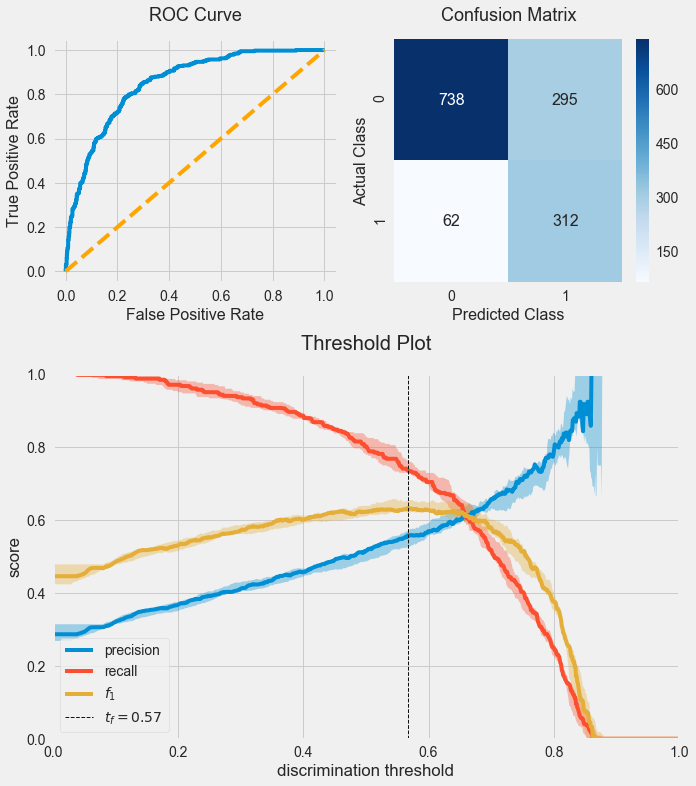

In [74]:
results_visualisations(rforest_tuned, X_train, y_train, X_test, y_test, SEED)

# Saving results to dataframe
rforest_base = model_report(rforest_tuned, X_train , y_train, X_test, y_test, 'RandomForest')

### Random Over Sampling

In [75]:
ros_rforest_pipe = Pipeline(steps=[
    ('RandomOverSample', ros),
    ('RandomForest', rforest_tuned)
])

ros_rforest = model_results_summary(ros_rforest_pipe, X_train, y_train, X_test, y_test,
                                   cv_kwargs, model_name='ROS Random Forest')

ROS Random Forest CV Results Summary
Mean Training Recall 	 83.04%
Mean Validation Recall 	 80.74%

Mean Fitting Time 	 0.2513s
Mean Scoring Time 	 0.1056s

Holdout Dataset Classification Report for ROS Random Forest
              precision    recall  f1-score   support

           0       0.92      0.70      0.79      1033
           1       0.50      0.82      0.62       374

    accuracy                           0.73      1407
   macro avg       0.71      0.76      0.71      1407
weighted avg       0.80      0.73      0.75      1407



In [76]:
# Saving results to dataframe
rforest_ros = model_report(ros_rforest, X_train , y_train, X_test, y_test, 'ROS_RandomForest')

### SMOTE

In [77]:
smote_rforest_pipe = Pipeline(steps=[
    ('Smote', smote),
    ('RandomForest', rforest_tuned)
])

smote_rforest = model_results_summary(smote_rforest_pipe, X_train, y_train, X_test, y_test,
                                      cv_kwargs, model_name='SMOTE Random Forest')

SMOTE Random Forest CV Results Summary
Mean Training Recall 	 75.99%
Mean Validation Recall 	 74.05%

Mean Fitting Time 	 0.2757s
Mean Scoring Time 	 0.1050s

Holdout Dataset Classification Report for SMOTE Random Forest
              precision    recall  f1-score   support

           0       0.90      0.78      0.83      1033
           1       0.55      0.75      0.64       374

    accuracy                           0.77      1407
   macro avg       0.72      0.76      0.73      1407
weighted avg       0.80      0.77      0.78      1407



In [78]:
# Saving results to dataframe
rforest_smote = model_report(smote_rforest, X_train , y_train, X_test, y_test, 'SMOTE_RandomForest')

### ADASYN

In [79]:
adasyn_rforest_pipe = Pipeline(steps=[
    ('Adasyn', adasyn),
    ('RandomForest', rforest_tuned)
])

adasyn_rforest = model_results_summary(adasyn_rforest_pipe, X_train, y_train, X_test, y_test, 
                                       cv_kwargs, model_name='ADASYN Random Forest')

ADASYN Random Forest CV Results Summary
Mean Training Recall 	 76.24%
Mean Validation Recall 	 73.85%

Mean Fitting Time 	 0.3138s
Mean Scoring Time 	 0.1059s

Holdout Dataset Classification Report for ADASYN Random Forest
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      1033
           1       0.54      0.76      0.63       374

    accuracy                           0.76      1407
   macro avg       0.72      0.76      0.73      1407
weighted avg       0.80      0.76      0.77      1407



In [80]:
# Saving results to dataframe
rforest_adasyn = model_report(adasyn_rforest, X_train , y_train, X_test, y_test, 'ADASYN_RandomForest')

### Comparing Baseline vs Resampling Performance

In [82]:
rforest_performance = pd.concat([rforest_base, rforest_ros, rforest_smote, rforest_adasyn], axis=0)
rforest_performance

,Model,Accuracy,ROC_AUC,Precision,Recall,F1
0,RandomForest,0.746,0.774,0.514,0.834,0.636
0,ROS_RandomForest,0.733,0.761,0.499,0.821,0.621
0,SMOTE_RandomForest,0.770,0.765,0.549,0.754,0.635
0,ADASYN_RandomForest,0.762,0.763,0.537,0.765,0.631
